In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('/content/drive/MyDrive/'))

In [3]:
import json
import tarfile

from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [4]:
!pip install pymatgen megnet

In [5]:
from pymatgen.core import Structure, Element
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

In [6]:
seed = 20
rng = np.random.default_rng(seed)

# Prepare data

In [7]:
dataset_path = '/content/drive/MyDrive/dichalcogenides_public.tar.gz'

In [8]:
with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall('./data/')

In [9]:
new_dataset_path = Path('./data/dichalcogenides_public')

In [10]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

In [11]:
targets = pd.read_csv(new_dataset_path / "targets.csv", index_col=0)

In [12]:
targets.sample(5)

,band_gap
_id,
6141e1014e27a1844a5f0318,1.1377
61428f53baaf234b35290706,1.0590
6141d9ce4e27a1844a5f0258,1.1387
6141dece4e27a1844a5f02e6,1.1451
6141e3903ac25c70a5c6c997,0.4076


In [13]:
struct = {
    item.name.strip(".json"): read_pymatgen_dict(item)
    for item in (new_dataset_path / "structures").iterdir()
}

In [14]:
struct['6141cf0f51c1cbd9654b8870']

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
    pbc : True True True
PeriodicSite: Mo (1.276e-07, 1.842, 3.72) [0.04167, 0.08333, 0.25]
PeriodicSite: Mo (-1.595, 4.605, 3.72) [0.04167, 0.2083, 0.25]
PeriodicSite: Mo (-3.19, 7.368, 3.72) [0.04167, 0.3333, 0.25]
PeriodicSite: Mo (-4.785, 10.13, 3.72) [0.04167, 0.4583, 0.25]
PeriodicSite: Mo (-6.381, 12.89, 3.72) [0.04167, 0.5833, 0.25]
PeriodicSite: Mo (-7.976, 15.66, 3.72) [0.04167, 0.7083, 0.25]
PeriodicSite: Mo (-9.571, 18.42, 3.72) [0.04167, 0.8333, 0.25]
PeriodicSite: Mo (-11.17, 21.18, 3.72) [0.04167, 0.9583, 0.25]
PeriodicSite: Mo (3.19, 1.842, 3.72) [0.1667, 0.08333, 0.25]
PeriodicSite: Mo (1.595, 4.605, 3.72) [0.1667, 0.2083, 0.25]
PeriodicSite: Mo (8.508e-08, 7.368, 3.72) [0.1667, 0.3333, 0.25]

In [15]:
print(struct['6141cf26baaf234b352901a6'].composition)
print(struct['6141cf0f51c1cbd9654b8870'].composition)
print(struct['6141cf254e27a1844a5f0018'].composition)

Mo63 W1 S126
Mo64 S126
Mo63 W1 Se1 S126


In [16]:
print(struct['6141cf254e27a1844a5f0018'].density)
# print(struct['6141cf254e27a1844a5f0018'].species)
print(struct['6141cf254e27a1844a5f0018'][0])
print(struct['6141cf254e27a1844a5f0018'].composition)
print(struct['6141cf254e27a1844a5f0018'].composition.elements)
print(struct['6141cf254e27a1844a5f0018'].volume)
print(struct['6141cf254e27a1844a5f0018'].num_sites)

2.0470128662062193 g cm^-3
[1.27612629e-07 1.84192955e+00 3.71975100e+00] Mo
Mo63 W1 Se1 S126
[Element Mo, Element W, Element Se, Element S]
8393.668021812642
191


In [17]:
data = pd.DataFrame(columns=["structures"], index=struct.keys())
data = data.assign(structures=struct.values(), targets=targets)

In [18]:
data['atoms_count'] = data.structures.apply(lambda x: x.num_sites)
data['elements_set'] = data.structures.apply(lambda x: x.composition.elements)

In [19]:
data.sample(5)

,structures,targets,atoms_count,elements_set
6141db54ee0a3fd43fb47c33,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3585,191,"[Mo, Se, S]"
6141d01d3ac25c70a5c6c883,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4083,189,"[Mo, S]"
6142025c9cbada84a8676c03,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.8074,192,"[Mo, W, Se, S]"
6141cf1e4e27a1844a5f000c,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1459,191,"[Mo, W, Se, S]"
6141f6f3ee0a3fd43fb47dc1,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3582,191,"[Mo, Se, S]"


<Axes: xlabel='atoms_count', ylabel='count'>

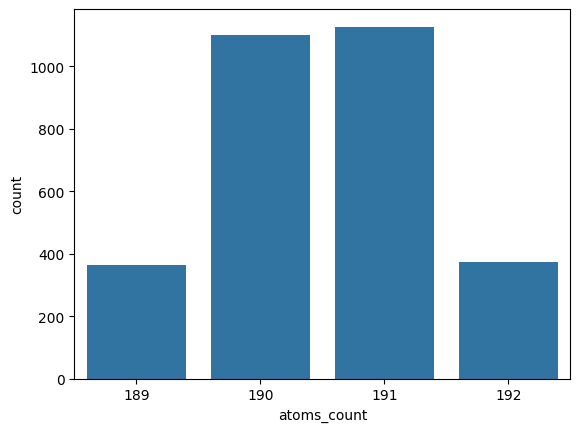

In [20]:
sns.countplot(data=data, x='atoms_count')

In [21]:
MAX_ATOMS = 192
ATOM_FEATURES = 16

In [22]:
unique_elements_set = set()

for elements in data.elements_set:
  unique_elements_set.update(elements)

unique_elements_set = list(unique_elements_set)

In [23]:
unique_elements_set

[Element S, Element Mo, Element Se, Element W]

In [24]:
element_to_index = {elem: Element(elem).Z for elem in unique_elements_set}

element_to_index

{Element S: 16, Element Mo: 42, Element Se: 34, Element W: 74}

In [25]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=seed)

In [26]:
test_data.shape

(742, 4)

In [27]:
cutoff = 5.0
graph_converter = CrystalGraph(cutoff=cutoff)

In [28]:
graph = graph_converter.convert(struct['6141cf0f51c1cbd9654b8870'])

In [29]:
graph

{'atom': [42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  42,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  

In [30]:
np.max(graph['bond'])

4.4691796

In [31]:
print(graph['bond'].shape)
print(graph['index1'].shape)
print(graph['index2'].shape)

(3508,)
(3508,)
(3508,)


In [32]:
# for i in range(len(graph['bond'])):
#   if graph['index2'][i] > graph['index1'][i]:
#     print('more')
#   else:
#     print('less')

# count = 0
# for i in range(len(graph['bond'])):
#   for j in range(len(graph['bond'])):
#     if i != j and graph['index1'][i] == graph['index2'][j] and graph['index1'][j] == graph['index2'][i]:
#       count+=1
# print(count)

# Build model

In [33]:
class InputEmbedding:
  def __init__(self, embed_size: int, elements_to_chemical_numbers: dict,
               max_atoms: int, random_seed: int = 21) -> None:
     self.rng = np.random.default_rng(random_seed)
     self.max_atoms = max_atoms
     self.embeddings = self.rng.standard_normal((max(elements_to_chemical_numbers.values()) + 1,
                                                 embed_size))

  def build_adjacency_matrix(self, graph) -> np.ndarray:
      self.num_atoms = len(graph['atom'])
      adjacency_matrix = np.zeros((self.num_atoms, self.num_atoms), dtype=int)

      for i, j in zip(graph['index1'], graph['index2']):
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1

      return adjacency_matrix

  def add_padding(self, adjacency_matrix, atom_embeddings):
      self.padding_size = self.max_atoms - self.num_atoms

      if self.padding_size == 0:
          return adjacency_matrix, atom_embeddings

      padded_adjacency_matrix = np.pad(adjacency_matrix,
                                       ((0, self.padding_size),
                                        (0, self.padding_size)),
                                      mode='constant')

      padding_embeddings = np.zeros((self.padding_size, atom_embeddings.shape[1]))
      padded_atom_embeddings = np.vstack((atom_embeddings, padding_embeddings))

      return padded_adjacency_matrix, padded_atom_embeddings


  def normalize_adj(self, A : np.ndarray) -> np.ndarray:
      I = np.eye(A.shape[0])
      A_hat = A + I
      D_hat = np.diag(np.sum(A_hat, axis=1))
      D_hat_inv_sqrt = np.sqrt(np.linalg.inv(D_hat))
      return D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt

  def feedforward(self, s : Structure):
      self.graph = graph_converter.convert(s)
      self.indexes = self.graph['atom']

      embeddings = self.embeddings[self.indexes]
      A = self.build_adjacency_matrix(self.graph)

      A, embeddings = self.add_padding(A, embeddings)
      A_norm = self.normalize_adj(A)

      return A_norm, embeddings

  def backprop(self, delta: np.ndarray, lr: float) -> None:
      if self.padding_size > 0:
          delta = delta[:-self.padding_size]

      d_embeddings = np.zeros_like(self.embeddings)
      np.add.at(d_embeddings, self.indexes, delta)

      self.embeddings -= lr * d_embeddings

In [34]:
class GraphConvLayer:
    def __init__(self, input_dim : int , output_dim : int, random_seed : int = 21) -> None:
       self.rng = np.random.default_rng(random_seed)

       self.W = self.rng.standard_normal((input_dim, output_dim))

    def feedforward(self, A_norm : np.ndarray, X : np.ndarray):
        self.A_norm = A_norm
        self.X = X
        self.Z = self.A_norm @ X @ self.W
        # ReLU activation
        self.H = np.maximum(0, self.Z)
        return self.A_norm, self.H

    def backprop(self, dH : np.ndarray, lr: float):
        # d_relu
        dZ = dH * (self.Z > 0)

        dW = (self.A_norm @ self.X).T @ dZ
        dX = self.A_norm.T @ (dZ @ self.W.T)

        self.W -= lr * dW

        return dX

In [35]:
class Linear():
    def __init__(self, in_neurons: int, out_neurons: int, random_seed: int = 42) -> None:
        # random generator
        self.rng = np.random.default_rng(random_seed)

        # parameter k for initialize weights
        self.k = np.sqrt(6. / (in_neurons + out_neurons))
        # initialize layer weights (Xavier)
        self.W = self.rng.uniform(-self.k, self.k + 1e-5, size=(out_neurons, in_neurons))
        # initialize bias
        self.b = self.rng.random((out_neurons, 1)) * 2 - 1

        # weight and bias changes
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

        # result from previous layer (current input)
        self.a = None

    def feedforward(self, x: np.ndarray) -> np.ndarray:
        self.a = x
        return self.W @ x + self.b

    def backprop(self, delta: np.ndarray, lr: float, update_params: bool = True) -> np.ndarray:
        self.dW = delta @ self.a.T
        self.db = np.sum(delta, axis=1, keepdims=True)
        new_delta = self.W.T @ delta

        # update params
        # assert self.W.shape == self.dW.shape
        if update_params:
            self.W -= lr * self.dW
            self.b -= lr * self.db

        return new_delta

In [36]:
class GraphNetwork:
    def __init__(self, atoms_count : int, embed_size: int, seed:int = 21) -> None:
        self.atoms_count = atoms_count
        self.embed_size = embed_size

        self.InputLayer = InputEmbedding(embed_size=self.embed_size, elements_to_chemical_numbers = element_to_index,
               max_atoms=self.atoms_count, random_seed=seed)

        self.Layer1 = GraphConvLayer(input_dim=self.embed_size, output_dim=self.embed_size * 2, random_seed=seed)
        self.Layer2 = GraphConvLayer(input_dim=self.embed_size * 2, output_dim=self.embed_size, random_seed=seed)

        self.Head = Linear(in_neurons=self.embed_size, out_neurons=1, random_seed=seed)

    def feedforward(self, s : Structure):
        A_norm, embeddings = self.InputLayer.feedforward(s)
        A_norm, embeddings = self.Layer1.feedforward(A_norm=A_norm, X=embeddings)
        A_norm, embeddings = self.Layer2.feedforward(A_norm=A_norm, X=embeddings)

        # Mean pooling
        x = np.mean(embeddings, axis=0).reshape(-1, 1)

        return self.Head.feedforward(x)

    def backprop(self, d_output: np.ndarray, lr: float) -> None:
        d_x = self.Head.backprop(d_output, lr)

        d_embeddings = np.repeat(d_x.reshape(-1)[np.newaxis, :], self.atoms_count, axis=0) / self.atoms_count

        d_embeddings = self.Layer2.backprop(dH = d_embeddings, lr=lr)
        d_embeddings = self.Layer1.backprop(dH = d_embeddings, lr=lr)
        self.InputLayer.backprop(delta=d_embeddings, lr=lr)

In [37]:
model = GraphNetwork(atoms_count=MAX_ATOMS, embed_size=ATOM_FEATURES, seed=seed)

# Train

In [38]:
def energy_within_threshold(prediction, target):
    # compute absolute error on energy per system.
    # then count the no. of systems where max energy error is < 0.02.
    e_thresh = 0.02
    error_energy = np.abs(target - prediction)

    success = np.count_nonzero(error_energy < e_thresh)
    total = target.size
    return success / total

In [39]:
class MAE:
    def fn(self, pred:np.ndarray, true: np.ndarray) -> np.ndarray:
        return np.mean(np.abs(pred - true))

    def dfn(self, pred: np.ndarray, true: np.ndarray) -> np.ndarray:
        return np.sign(pred - true) / pred.size

In [40]:
mae = MAE()

In [41]:
epochs = 22
lr = 3e-4

In [42]:
train_loss_history , test_loss_history = [], []
ewt_train_history, ewt_test_history = [], []

In [43]:
train_dataset_size = train_data.shape[0]
test_dataset_size = test_data.shape[0]

order = np.arange(train_dataset_size)

In [44]:
def train(model : GraphNetwork, epochs: int = 1, lr: float = 1e-3) -> None:

    for epoch in range(epochs):
        train_loss_value, test_loss_value = 0, 0
        preds, trues = [], []

        # Train phase
        rng.shuffle(order)
        for i in tqdm(range(train_dataset_size)):
            pred = model.feedforward(train_data.iloc[i].structures)
            true = np.array(train_data.iloc[i].targets).reshape(-1,1)

            preds.append(pred.item())
            trues.append(true.item())
            train_loss_value += mae.fn(pred.item(), true.item())

            d_output = mae.dfn(pred, true)
            model.backprop(d_output, lr)

        train_ewt = energy_within_threshold(prediction=np.array(preds), target=np.array(trues))
        ewt_train_history.append(train_ewt)

        preds, trues = [], []

        # Test phase
        for i in tqdm(range(test_dataset_size)):
            pred = model.feedforward(test_data.iloc[i].structures)
            true = np.array(test_data.iloc[i].targets).reshape(-1,1)

            preds.append(pred.item())
            trues.append(true.item())
            test_loss_value += mae.fn(pred.item(), true.item())

        test_ewt = energy_within_threshold(prediction=np.array(preds), target=np.array(trues))
        ewt_test_history.append(test_ewt)

        train_loss_value /= train_dataset_size
        test_loss_value /= test_dataset_size
        train_loss_history.append(train_loss_value)
        test_loss_history.append(test_loss_value)

        print(f'''
          Epoch: {epoch + 1}/{epochs},
          Train loss : {train_loss_value},
          Test loss : {test_loss_value},
          Train EWT : {train_ewt},
          Test EWT: {test_ewt}
        ''')


In [45]:
train(model=model, epochs=epochs, lr=lr)

100%|██████████| 742/742 [00:13<00:00, 54.25it/s]



          Epoch: 1/22,
          Train loss : 0.8060278626450803,
          Test loss : 0.4099500359557022,
          Train EWT : 0.015287769784172662,
          Test EWT: 0.0
        


100%|██████████| 742/742 [00:12<00:00, 61.31it/s]



          Epoch: 2/22,
          Train loss : 0.48552420034025234,
          Test loss : 0.4021488065467842,
          Train EWT : 0.02473021582733813,
          Test EWT: 0.0026954177897574125
        


100%|██████████| 742/742 [00:09<00:00, 77.82it/s]



          Epoch: 3/22,
          Train loss : 0.4603472043862641,
          Test loss : 0.41278088909174443,
          Train EWT : 0.02877697841726619,
          Test EWT: 0.09838274932614555
        


100%|██████████| 742/742 [00:12<00:00, 57.88it/s]



          Epoch: 4/22,
          Train loss : 0.44360252261340366,
          Test loss : 0.3692445629441862,
          Train EWT : 0.023830935251798562,
          Test EWT: 0.0
        


100%|██████████| 742/742 [00:12<00:00, 57.44it/s]



          Epoch: 5/22,
          Train loss : 0.42559958427154143,
          Test loss : 0.36301798409163194,
          Train EWT : 0.03462230215827338,
          Test EWT: 0.004043126684636119
        


100%|██████████| 742/742 [00:13<00:00, 56.44it/s]



          Epoch: 6/22,
          Train loss : 0.4051622694069849,
          Test loss : 0.37001252393102607,
          Train EWT : 0.026079136690647483,
          Test EWT: 0.11320754716981132
        


100%|██████████| 742/742 [00:12<00:00, 57.76it/s]



          Epoch: 7/22,
          Train loss : 0.3896154781093733,
          Test loss : 0.32691053708907547,
          Train EWT : 0.03462230215827338,
          Test EWT: 0.04582210242587601
        


100%|██████████| 742/742 [00:10<00:00, 72.20it/s]



          Epoch: 8/22,
          Train loss : 0.37359292943580413,
          Test loss : 0.3159796925800619,
          Train EWT : 0.03597122302158273,
          Test EWT: 0.0013477088948787063
        


100%|██████████| 742/742 [00:09<00:00, 77.43it/s]



          Epoch: 9/22,
          Train loss : 0.36041133777458256,
          Test loss : 0.30316885102362745,
          Train EWT : 0.04091726618705036,
          Test EWT: 0.0013477088948787063
        


100%|██████████| 742/742 [00:13<00:00, 55.83it/s]



          Epoch: 10/22,
          Train loss : 0.34828281263811806,
          Test loss : 0.29281742384049436,
          Train EWT : 0.03911870503597122,
          Test EWT: 0.06064690026954178
        


100%|██████████| 742/742 [00:13<00:00, 55.44it/s]



          Epoch: 11/22,
          Train loss : 0.34067140661989265,
          Test loss : 0.3413303317571313,
          Train EWT : 0.03282374100719424,
          Test EWT: 0.06873315363881402
        


100%|██████████| 742/742 [00:13<00:00, 55.73it/s]



          Epoch: 12/22,
          Train loss : 0.3296939253744795,
          Test loss : 0.2688736485037835,
          Train EWT : 0.045413669064748204,
          Test EWT: 0.0026954177897574125
        


100%|██████████| 742/742 [00:10<00:00, 68.51it/s]



          Epoch: 13/22,
          Train loss : 0.318294265256322,
          Test loss : 0.2932284502939093,
          Train EWT : 0.044064748201438846,
          Test EWT: 0.10107816711590296
        


100%|██████████| 742/742 [00:09<00:00, 76.42it/s]



          Epoch: 14/22,
          Train loss : 0.3096599884539771,
          Test loss : 0.24494150092003153,
          Train EWT : 0.0539568345323741,
          Test EWT: 0.0013477088948787063
        


100%|██████████| 742/742 [00:10<00:00, 68.88it/s]



          Epoch: 15/22,
          Train loss : 0.30184954894362376,
          Test loss : 0.392416553684543,
          Train EWT : 0.03102517985611511,
          Test EWT: 0.014824797843665768
        


100%|██████████| 742/742 [00:13<00:00, 56.08it/s]



          Epoch: 16/22,
          Train loss : 0.29451586618847747,
          Test loss : 0.2470937915498986,
          Train EWT : 0.026528776978417268,
          Test EWT: 0.08490566037735849
        


100%|██████████| 742/742 [00:13<00:00, 53.47it/s]



          Epoch: 17/22,
          Train loss : 0.2817129607256671,
          Test loss : 0.21712693431686667,
          Train EWT : 0.06339928057553956,
          Test EWT: 0.014824797843665768
        


100%|██████████| 742/742 [00:13<00:00, 56.02it/s]



          Epoch: 18/22,
          Train loss : 0.2839684401294488,
          Test loss : 0.41883700371107097,
          Train EWT : 0.049910071942446045,
          Test EWT: 0.0
        


100%|██████████| 742/742 [00:11<00:00, 65.25it/s]



          Epoch: 19/22,
          Train loss : 0.27721693598765235,
          Test loss : 0.3212310646322139,
          Train EWT : 0.040467625899280574,
          Test EWT: 0.0026954177897574125
        


100%|██████████| 742/742 [00:10<00:00, 74.17it/s]



          Epoch: 20/22,
          Train loss : 0.27129146111261027,
          Test loss : 0.23356758850337708,
          Train EWT : 0.07598920863309352,
          Test EWT: 0.09299191374663072
        


100%|██████████| 742/742 [00:12<00:00, 60.72it/s]



          Epoch: 21/22,
          Train loss : 0.26222014537885285,
          Test loss : 0.22743244820278402,
          Train EWT : 0.10251798561151079,
          Test EWT: 0.09703504043126684
        


100%|██████████| 742/742 [00:13<00:00, 56.51it/s]


          Epoch: 22/22,
          Train loss : 0.2591699700471853,
          Test loss : 0.2625655843019411,
          Train EWT : 0.10971223021582734,
          Test EWT: 0.11455525606469003
        


Text(0, 0.5, 'MAE')

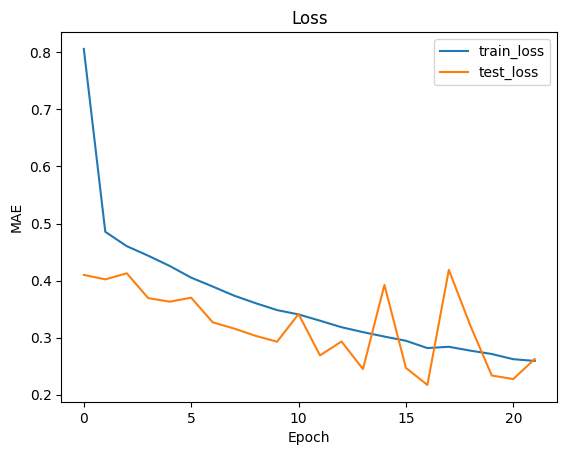

In [46]:
plt.plot(train_loss_history, label="train_loss")
plt.plot(test_loss_history, label="test_loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('MAE')

Text(0.5, 0, 'Epoch')

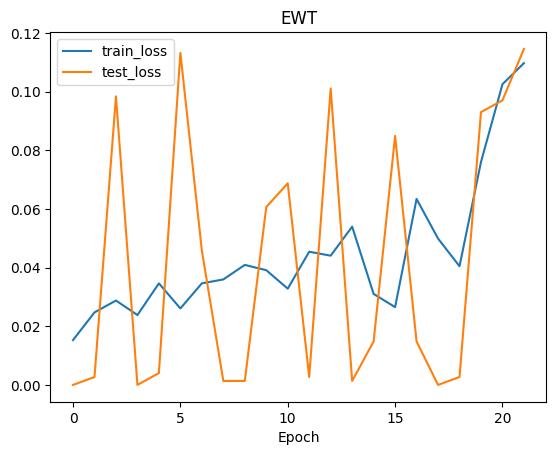

In [47]:
plt.plot(ewt_train_history, label="train_loss")
plt.plot(ewt_test_history, label="test_loss")
plt.legend()
plt.title("EWT")
plt.xlabel('Epoch')

In [48]:
def predict(model: GraphNetwork):
      y_pred, y_true = [], []

      for i in tqdm(range(test_dataset_size)):
          pred = model.feedforward(test_data.iloc[i].structures)
          true = np.array(test_data.iloc[i].targets).reshape(-1,1)

          y_pred.append(pred.item())
          y_true.append(true.item())
      return np.array(y_pred), np.array(y_true)

In [49]:
y_pred, y_true = predict(model=model)

100%|██████████| 742/742 [00:10<00:00, 67.69it/s]


In [50]:
r2_score(y_true, y_pred)

0.47390705319298043